In [1]:
import os
from typing import Callable

import matplotlib.pyplot as plt
import pandas as pd

from edgedroid.models.sampling import *
from edgedroid.models.timings import *
from edgedroid.models.sampling.adaptive import _aperiodic_instant_iterator
from typing import NamedTuple
import scipy.stats as stats


power_mw = {
    "comm": 0.045,
    "idle": 0.015
}  # Watts

warmup_steps = 25
samples_per_scheme = 100

timing_models: Dict[str, Callable[[], ExecutionTimeModel]] = {
    "fitted-naive": lambda: FittedNaiveExecutionTimeModel(dist=stats.exponnorm),
    "rolling-ttf-high": lambda: ExpKernelRollingTTFETModel(neuroticism=1.0),
    "rolling-ttf-low": lambda: ExpKernelRollingTTFETModel(neuroticism=1.0),
    "fitted-rolling-ttf-high":  lambda: DistExpKernelRollingTTFETModel(neuroticism=1.0, dist=stats.exponnorm),
    "fitted-rolling-ttf-low":  lambda: DistExpKernelRollingTTFETModel(neuroticism=0.0, dist=stats.exponnorm),
}

class SamplingResult(NamedTuple):
    duration: float
    wait_time: float
    ttf: float
    num_samples: int


class ExpSampling(BaseFrameSamplingModel, abc.ABC):
    @abc.abstractmethod
    def constant_rtt_sampling(self, rtt: float, proc_time: float, prev_ttf: float,
                              target_exec_time: float) -> SamplingResult:
        pass


class AdaptiveSamplingMixin(BaseAperiodicFrameSamplingModel, ExpSampling, abc.ABC):
    def constant_rtt_sampling(self, rtt: float, proc_time: float, prev_ttf: float,
                              target_exec_time: float) -> SamplingResult:
        self._timing_model.advance(prev_ttf)
        alpha = self.get_alpha()
        beta = self.get_beta()

        instant_iter = _aperiodic_instant_iterator(
            mu=self._timing_model.get_mean_execution_time(),
            alpha=alpha,
            beta=beta,
        )
        # first instant doesn't depend on RTT
        instant = next(instant_iter)
        num_samples = 1

        while instant <= target_exec_time:
            instant = max(next(instant_iter), instant + rtt)
            num_samples += 1

        self.update_timings([rtt - proc_time] * num_samples, [proc_time] * num_samples)
        duration = instant + rtt
        return SamplingResult(duration=duration, wait_time=instant - target_exec_time, ttf=duration - target_exec_time,
                              num_samples=num_samples)


class AdaptivePowerSampling(AperiodicPowerFrameSamplingModel, AdaptiveSamplingMixin):
    pass

In [2]:
import edgedroid.data as e_data

data, *_ = e_data.load_default_exec_time_data()
data

,run_id,ttf,exec_time,neuroticism
0,134146,0.597441,3.654797,0.375
1,134146,0.553513,4.438645,0.375
2,134146,0.561716,2.943222,0.375
3,134146,0.586512,5.405761,0.375
4,134146,0.558940,5.225161,0.375
...,...,...,...,...
6755,137353,0.557074,6.439071,0.625
6756,137353,0.534339,4.680858,0.625
6757,137353,0.560288,3.467878,0.625
6758,137353,0.579000,2.325759,0.625


In [3]:
rayleigh_mean = stats.rayleigh.freeze(*stats.rayleigh.fit(data["exec_time"])).mean()
rayleigh_mean

5.897986672430338

In [4]:
import warnings


def get_sampling_scheme():
    return AdaptivePowerSampling.from_default_data(execution_time_model=ConstantExecutionTimeModel(execution_time_seconds=rayleigh_mean))

def evaluate_timing_model(name: str, repetition: int, num_steps: int, rtt: float, proc_time: float) -> pd.DataFrame:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sampling = get_sampling_scheme()
        timing = timing_models[name]()

    rows = deque()

    prev_ttf = rtt
    for step in range(1, num_steps + 1):
        exec_time = timing.advance(prev_ttf).get_execution_time()
        sampling_result = sampling.constant_rtt_sampling(rtt=rtt, proc_time=proc_time, prev_ttf=prev_ttf, target_exec_time=exec_time)

        # energy calculation
        comm_time = (rtt - proc_time) * sampling_result.num_samples
        idle_time = sampling_result.duration - comm_time
        comm_energy = comm_time * power_mw["comm"]
        idle_energy = idle_time * power_mw["idle"]

        energy = comm_energy + idle_energy

        rows.append(
            {
                "timing_model": name,
                "rtt": rtt,
                "proc_time": proc_time,
                "repetition": repetition,
                "execution_time": exec_time,
                "step_duration": sampling_result.duration,
                "samples": sampling_result.num_samples,
                "ttf": sampling_result.ttf,
                "wait_time": sampling_result.wait_time,
                "energy": energy,
            }
        )

    return pd.DataFrame(rows)

In [5]:
import multiprocess as mp
from tqdm.notebook import tqdm
import itertools as it

rtts = np.linspace(0, 5, 11)[1:]
proc_time = 0.3

runs_per_model = 60
task_steps = 100

results = deque()
combs = list(it.product(timing_models.keys(), range(1, runs_per_model + 1), rtts))

with mp.Pool() as pool, tqdm(total=len(combs), desc="Running sampling tests...") as bar:
    def _callback(df: pd.DataFrame):
        results.append(df)
        bar.update()

    def _errback(e):
        raise e

    for name, rep, rtt in combs:
        pool.apply_async(evaluate_timing_model, args=(name, rep, task_steps, rtt, proc_time), callback=_callback, error_callback=_errback)

    pool.close()
    pool.join()

results = pd.concat(results, ignore_index=True)

Running sampling tests...:   0%|          | 0/3000 [00:00<?, ?it/s]

In [6]:
results

,timing_model,rtt,proc_time,repetition,execution_time,step_duration,samples,ttf,wait_time,energy
0,fitted-naive,0.5,0.3,1,3.130988,3.798128,3,0.667141,0.167141,0.074972
1,fitted-naive,0.5,0.3,1,4.417253,5.922590,2,1.505337,1.005337,0.100839
2,fitted-naive,0.5,0.3,1,3.276339,3.916017,1,0.639678,0.139678,0.064740
3,fitted-naive,0.5,0.3,1,3.210787,3.916017,1,0.705231,0.205231,0.064740
4,fitted-naive,0.5,0.3,1,4.718081,5.922590,2,1.204508,0.704508,0.100839
...,...,...,...,...,...,...,...,...,...,...
299995,fitted-rolling-ttf-low,5.0,0.3,60,8.117971,14.784591,1,6.666620,1.666620,0.362769
299996,fitted-rolling-ttf-low,5.0,0.3,60,5.856411,14.784591,1,8.928180,3.928180,0.362769
299997,fitted-rolling-ttf-low,5.0,0.3,60,6.000071,14.784591,1,8.784521,3.784521,0.362769
299998,fitted-rolling-ttf-low,5.0,0.3,60,3.283844,14.784591,1,11.500747,6.500747,0.362769


In [7]:
energy_per_rtt = (
    results
    .groupby(["timing_model", "rtt", "repetition"])
    ["energy"]
    .mean()
    .groupby(["timing_model", "rtt"])
    .mean()
    .reset_index()
)
energy_per_rtt

,timing_model,rtt,energy
0,fitted-naive,0.5,0.125137
1,fitted-naive,1.0,0.163056
2,fitted-naive,1.5,0.194162
3,fitted-naive,2.0,0.222978
4,fitted-naive,2.5,0.252995
5,fitted-naive,3.0,0.279276
6,fitted-naive,3.5,0.306944
7,fitted-naive,4.0,0.333871
8,fitted-naive,4.5,0.361241
9,fitted-naive,5.0,0.387337


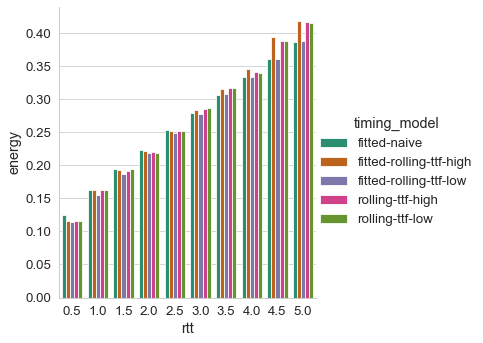

In [8]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("Dark2")

fg = sns.catplot(
    kind="bar",
    dodge=True,
    data=energy_per_rtt,
    x="rtt",
    y="energy",
    hue="timing_model",
)
plt.show()